In [1]:
import os
import gym
import numpy as np
import torch
from tqdm import tqdm
from CustomGymEnvs import MujocoGraphWrapper, FetchReachGraphWrapper
from pathlib import Path
from Graph_SAC.sac import SAC
from utils import state_2_graphbatch, load_object
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
env_name = 'HalfCheetah-v2'

exp_type = 'graph'
seed = 12345

In [3]:
exp_path = os.path.join(Path(os.getcwd()), 'Data', env_name, exp_type)
args = load_object(os.path.join(exp_path, 'seed0', 'parameters.pkl'))
args.env_name = env_name
args.seed = seed

In [4]:
experiment_seed = os.listdir(exp_path)
experiment_seed = [d for d in experiment_seed if os.path.isdir(os.path.join(exp_path, d))]
# experiment_seed = experiment_seed[:2]
if args.seed < len(experiment_seed):
    experiment_seed = [f'seed{args.seed}']
    exp_path = os.path.join(exp_path, experiment_seed[0])


# Environment
if 'FetchReach' in args.env_name:
    env = FetchReachGraphWrapper(gym.make(args.env_name))
else:
    env = MujocoGraphWrapper(gym.make(args.env_name))

num_node_features = env.observation_space['node_features'].shape[1]
num_edge_features = env.observation_space['edge_features'].shape[1]
num_global_features = env.observation_space['global_features'].shape[0]

edge_list = env.robot_graph.edge_list
node_list = env.robot_graph.node_list

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() and args.cuda else 'cpu')
device = torch.device('cpu')
args.cuda = False
num_episodes = 5
render = False

In [6]:
def process_joint_name(joint_name):
    separated = joint_name.split(':')[1].split('_') if 'robot0' in joint_name else joint_name.split('_')
    final_key = ''
    for sk in separated:
        if len(sk) == 1:
            final_key += sk + '-'
        else:
            final_key += sk + ' '
    return final_key

joint_names = []
joint_indices = []
for edge_id, joint_list in enumerate(edge_list.values()):
    if len(joint_list) > 0:
        joint_names.append(
            process_joint_name(joint_list[0].attrib['name'])
            if len(joint_list) == 1
            else '\n'.join([process_joint_name(j.attrib['name']) for j in joint_list])
        )
        joint_indices.append(edge_id)

action_indices = [a for a in range(env.action_space.shape[0])]

In [7]:
edge_relevance = np.zeros(
    [len(joint_names),
     env.action_space.shape[0],
     len(experiment_seed),
     num_episodes,
     env.spec.max_episode_steps])

global_relevance = np.zeros([env.action_space.shape[0], len(experiment_seed)])

In [8]:
def calculate_relevance():
    for s, seed in enumerate(experiment_seed):
        seed = int(seed[-1])
        env.seed(seed)
        env.action_space.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        # Agent
        checkpoint_path = os.path.join(exp_path, f'seed{seed}', 'model') \
            if len(experiment_seed) > 1 \
            else os.path.join(exp_path, 'model')
        agent = SAC(num_node_features, num_edge_features, num_global_features, env.action_space, False, args)
        agent_relevance = SAC(num_node_features, num_edge_features, num_global_features, env.action_space, True, args)

        agent.load_checkpoint(checkpoint_path, evaluate=True)
        agent_relevance.load_checkpoint(checkpoint_path, evaluate=True)

        avg_reward = 0.

        for episode in tqdm(range(num_episodes)):
            state = env.reset()
            episode_reward = 0
            done = False
            step = 0
            while not done:
                for action_index in range(env.action_space.shape[0]):
                    batch_state = state_2_graphbatch(state).requires_grad_().to(device)
                    out = agent_relevance.policy.graph_net(batch_state)
                    out = agent_relevance.policy.mean_linear(out)[0]
                    output_relevance = torch.zeros_like(out.global_features)
                    output_relevance[action_index] = out.global_features[action_index]
                    batch_state.zero_grad_()
                    out.global_features.backward(output_relevance)

                    edge_rel = batch_state.edge_features.grad.sum(dim=1)
                    global_rel = batch_state.global_features.grad.sum(dim=1)
                    global_relevance[action_index, s] += global_rel
                    edge_relevance[:, action_index, s, episode, step] = edge_rel[joint_indices]
                step += 1
                action = agent.select_action(state_2_graphbatch(state), evaluate=True)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
                if render:
                    env.render()
            avg_reward += episode_reward
        avg_reward /= num_episodes

        print("----------------------------------------")
        print("Test Episodes: {}, Avg. Reward: {}".format(num_episodes, round(avg_reward, 2)))
        print("----------------------------------------")

    env.close()

In [21]:
def plot_joint_action_heatmap(data, width, height, title, file_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height), gridspec_kw={'width_ratios': (30, 1)})
    sns.heatmap(data, ax=ax1, cbar=False, cmap="YlGn", linewidth=1, vmin=np.min(data), vmax=np.max(data))
    ax1.set_xticks(np.arange(len(joint_names)) + 0.5, labels=[j for j in joint_names], rotation=45)
    ax1.set_title(title, fontsize=20, pad=40)
    ax1.set_ylabel("Action index")
    ax1.set_xlabel(f"Joints' names")

    ax3 = ax1.twiny()
    ax3.set_xlim([0, ax1.get_xlim()[1]])
    ax3.set_xticks(ax1.get_xticks())
    ax3.set_xticklabels(np.round(data.mean(axis=0), 2))

    plt.colorbar(plt.cm.ScalarMappable(cmap="YlGn", norm=plt.Normalize(vmin=np.min(data), vmax=np.max(data))), cax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_ylabel('Avg relevance score across seeds')

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax1.text(j + 0.5, i + 0.5, round(data[i, j], 3), color="black")

    plt.show()

/home/mehran/Documents/env/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed9/model


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed9/model


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

----------------------------------------
Test Episodes: 5, Avg. Reward: 1769.89
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed3/model
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed3/model


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

----------------------------------------
Test Episodes: 5, Avg. Reward: 1722.33
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed8/model
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed8/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.71s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1808.68
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed1/model
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed1/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00, 14.27s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1802.35
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed6/model


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed6/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:12<00:00, 14.58s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1626.75
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed0/model
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed0/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.93s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1766.78
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed5/model
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed5/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.60s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1676.05
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed7/model


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed7/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.27s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1741.1
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed2/model
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed2/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.68s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1608.83
----------------------------------------
Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed4/model


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

Loading models from /home/mehran/Documents/SAC_GCN/Data/HalfCheetah-v2/graph/seed4/model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:12<00:00, 14.57s/it]


----------------------------------------
Test Episodes: 5, Avg. Reward: 1820.3
----------------------------------------


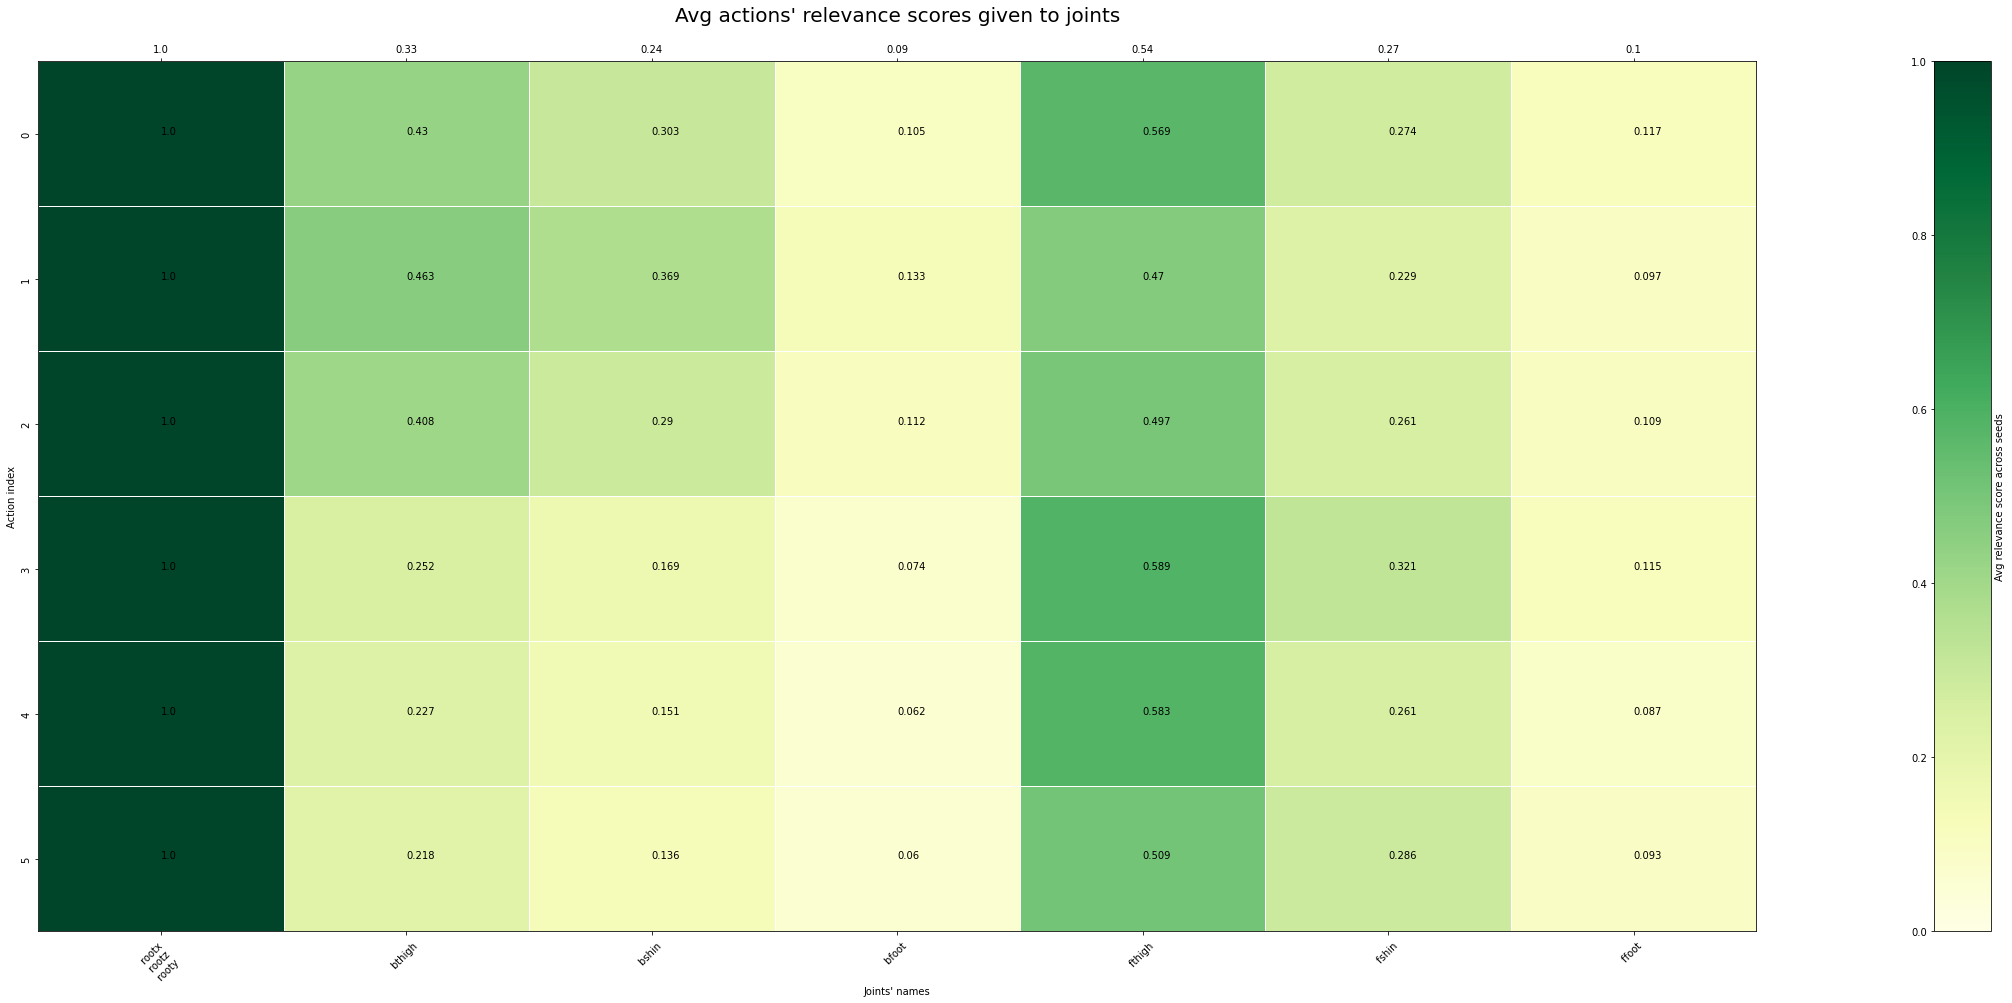

In [10]:
figure_width = 12
figure_height = 10

calculate_relevance()

fig_name = os.path.join(exp_path, 'edge_relevance_heatmap.jpg')
# average across steps in an episode, across episodes, then across seeds
avg_edge_rel = np.abs(edge_relevance).mean(axis=4).mean(axis=3).mean(axis=2)
# avg_edge_rel = edge_relevance.mean(axis=4).mean(axis=3).mean(axis=2)
avg_edge_rel /= np.max(np.abs(avg_edge_rel), axis=0)
plot_joint_action_heatmap(avg_edge_rel.T,
                          figure_width,
                          figure_height,
                          "Avg actions' relevance scores given to joints",
                          fig_name)

In [13]:
avg_edge_rel = np.abs(edge_relevance).mean(axis=4).mean(axis=3).mean(axis=2)

In [24]:
avg_edge_rel = edge_relevance.mean(axis=4).mean(axis=3).mean(axis=2)

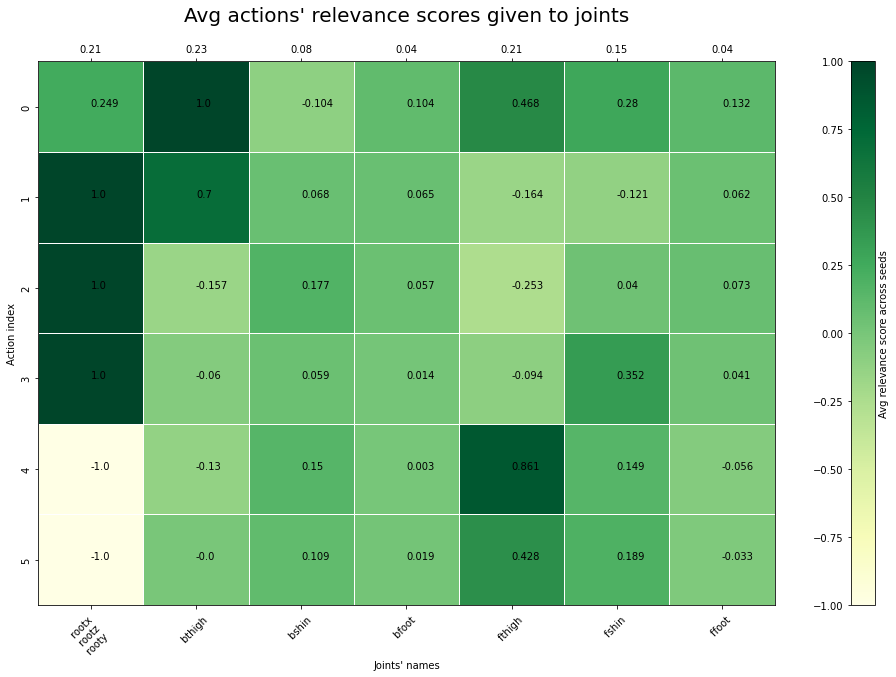

In [25]:
figure_width = 15
figure_height = 10
avg_edge_rel /= np.max(np.abs(avg_edge_rel), axis=0)
plot_joint_action_heatmap(avg_edge_rel.T,
                          figure_width,
                          figure_height,
                          "Avg actions' relevance scores given to joints",
                          fig_name)

In [34]:
edge_relevance.sum(axis=4).mean(axis=3).mean(axis=)

(7, 6, 10, 5)